In [1]:
!pip install split-folders

In [2]:
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import cv2
import plotly.express as px
import numpy as np
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

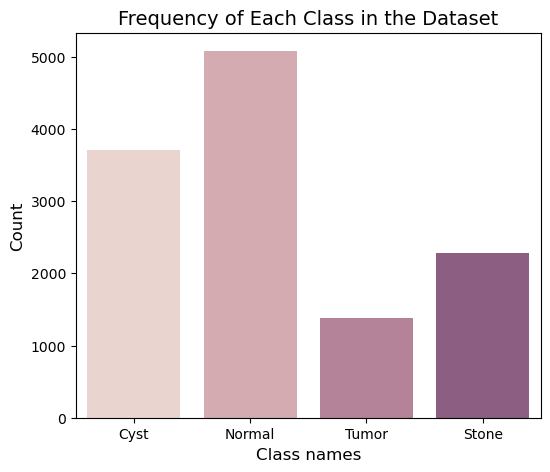

In [3]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone'] 

cyst = len(os.listdir('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst'))
normal = len(os.listdir('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal'))
stone = len(os.listdir('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone'))
tumor = len(os.listdir('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor'))

images = [cyst, normal, stone, tumor]

plt.figure(figsize=(6,5))
sns.barplot(x= class_names, y= images, palette= sns.cubehelix_palette())
plt.title('Frequency of Each Class in the Dataset', fontsize=14)
plt.xlabel('Class names', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(images)))
plt.show()
#px.pie(names= class_names, values= images, color_discrete_sequence=px.colors.sequential.BuGn)

In [4]:
splitfolders.ratio(
    "../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   ratio=(.8,.1,.1)
)


Copying files: 12446 files [01:38, 126.05 files/s]


In [5]:
"""
train = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=False,
        fill_mode="nearest",
        )
"""

'\ntrain = ImageDataGenerator(\n        rescale=1 / 255.0,\n        rotation_range=20,\n        zoom_range=0.05,\n        width_shift_range=0.05,\n        height_shift_range=0.05,\n        shear_range=0.05,\n        horizontal_flip=False,\n        fill_mode="nearest",\n        )\n'

In [6]:

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)
val = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory('./dataset/train',
                                          target_size=(180, 180),
                                          color_mode='rgb',
                                          class_mode = 'categorical',
                                          batch_size=100
                                         )

test_dataset = test.flow_from_directory('./dataset/test',
                                        target_size=(180, 180),
                                        color_mode='rgb',
                                        class_mode = 'categorical',                                  
                                        batch_size=100,
                                        shuffle = False
                                       )

valid_dataset = val.flow_from_directory('./dataset/val',
                                        target_size=(180, 180),
                                        color_mode='rgb',
                                        class_mode = 'categorical',
                                        batch_size=100
                                       )

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [7]:
import pandas as pd
df=pd.DataFrame(train_dataset.classes)
df.value_counts()



1    4061
0    2967
3    1826
2    1101
dtype: int64

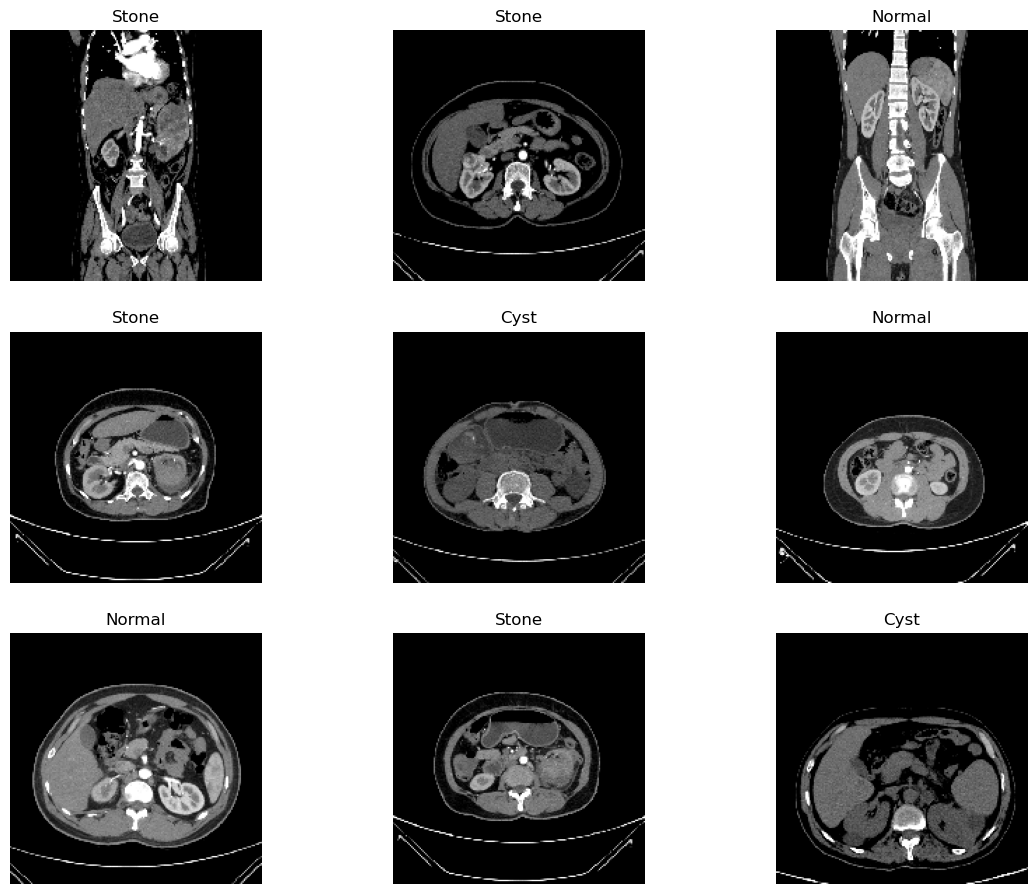

In [8]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone'] 
def class_type(dataset, n_images):

    i = 1
    images, labels = dataset.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[np.argmax(label)])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    plt.show()

class_type(train_dataset, 10)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.applications import ResNet50

In [10]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
resnet_weights_path

'../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
from tensorflow.keras import regularizers

In [13]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(Dense(512,activation=('relu'), kernel_regularizer=regularizers.l2(0.1), input_dim=2048)) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
model.add(Dense(4,activation=('softmax'))) 
model.layers[0].trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [14]:
model.layers

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 24,702,980
Trainable params: 1,115,268
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
from tensorflow.keras.optimizers import SGD,Adam
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [18]:
history03 = model.fit_generator(
        train_dataset,
        steps_per_epoch= 32,
        epochs = 100,
        validation_data = valid_dataset,
        validation_steps= 32,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

/tmp/ipykernel_26/2062388593.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history03 = model.fit_generator(


Epoch 1/100
32/32 [==============================] - 28s 633ms/step - loss: 59.0529 - accuracy: 0.3781 - val_loss: 30.2772 - val_accuracy: 0.4082
Epoch 2/100
32/32 [==============================] - 12s 383ms/step - loss: 16.2834 - accuracy: 0.3988
Epoch 3/100
32/32 [==============================] - 13s 388ms/step - loss: 4.1666 - accuracy: 0.4190
Epoch 4/100
32/32 [==============================] - 12s 377ms/step - loss: 1.8103 - accuracy: 0.4116
Epoch 5/100
32/32 [==============================] - 12s 375ms/step - loss: 1.3901 - accuracy: 0.3859
Epoch 6/100
32/32 [==============================] - 12s 383ms/step - loss: 1.3009 - accuracy: 0.4031
Epoch 7/100
32/32 [==============================] - 12s 377ms/step - loss: 1.2774 - accuracy: 0.4150
Epoch 8/100
32/32 [==============================] - 12s 380ms/step - loss: 1.2887 - accuracy: 0.4047
Epoch 9/100
32/32 [==============================] - 12s 385ms/step - loss: 1.2952 - accuracy: 0.3988
Epoch 10/100
32/32 [=================

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (180,180,3))
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [20]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [22]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [23]:
from tensorflow.keras import regularizers

In [24]:
#model.add(Dense(1024,activation=('relu'),input_dim=12800))
#model.add(Dense(512,activation=('relu'))) 
#kernel_regularizer=tensorflow.keras.regularizers.l1(0.001)

model.add(Dense(256,activation=('relu'), kernel_regularizer=regularizers.l2(0.01), input_dim=12800)) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(4,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 18,025,156
Trainable params: 10,389,892


In [25]:
from tensorflow.keras.optimizers import SGD,Adam
batch_size= 1218
epochs=15
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
history01= model.fit(train_dataset,
          validation_data=valid_dataset,
          epochs=10,
          #batch_size = batch_size
         )

Epoch 1/10
100/100 [==============================] - 54s 476ms/step - loss: 5.6858 - accuracy: 0.7140 - val_loss: 5.1262 - val_accuracy: 0.8986
Epoch 2/10
100/100 [==============================] - 42s 415ms/step - loss: 4.9108 - accuracy: 0.9521 - val_loss: 4.7131 - val_accuracy: 0.9887
Epoch 3/10
100/100 [==============================] - 43s 427ms/step - loss: 4.6270 - accuracy: 0.9871 - val_loss: 4.4987 - val_accuracy: 0.9968
Epoch 4/10
100/100 [==============================] - 42s 423ms/step - loss: 4.4190 - accuracy: 0.9940 - val_loss: 4.3095 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 42s 422ms/step - loss: 4.2351 - accuracy: 0.9978 - val_loss: 4.1386 - val_accuracy: 0.9992
Epoch 6/10
100/100 [==============================] - 43s 425ms/step - loss: 4.0630 - accuracy: 0.9987 - val_loss: 3.9775 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 42s 419ms/step - loss: 3.9027 - accuracy: 0.9988 - val_loss: 3.8177 - val_ac

In [27]:
history[0]

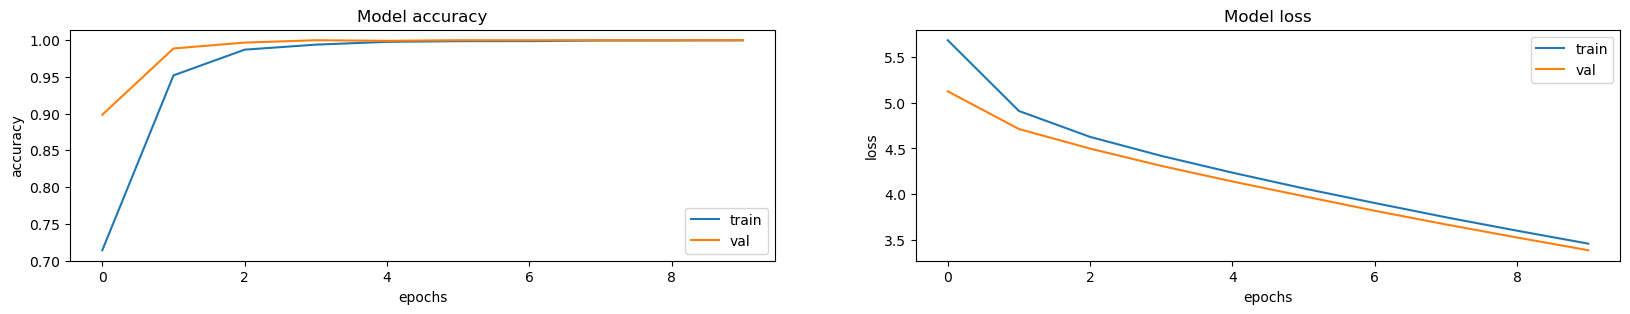

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history01.history[met])
    ax[i].plot(history01.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
predictions01 = model.predict(test_dataset)
model.evaluate(test_dataset)

13/13 [==============================] - 5s 356ms/step - loss: 3.3866 - accuracy: 0.9992


[3.3865909576416016, 0.9991993308067322]

Accuracy: 0.9991993594875901
Precision: 0.9982142857142857
Recall: 0.9989082969432315
F1_score: 0.9985568967004698


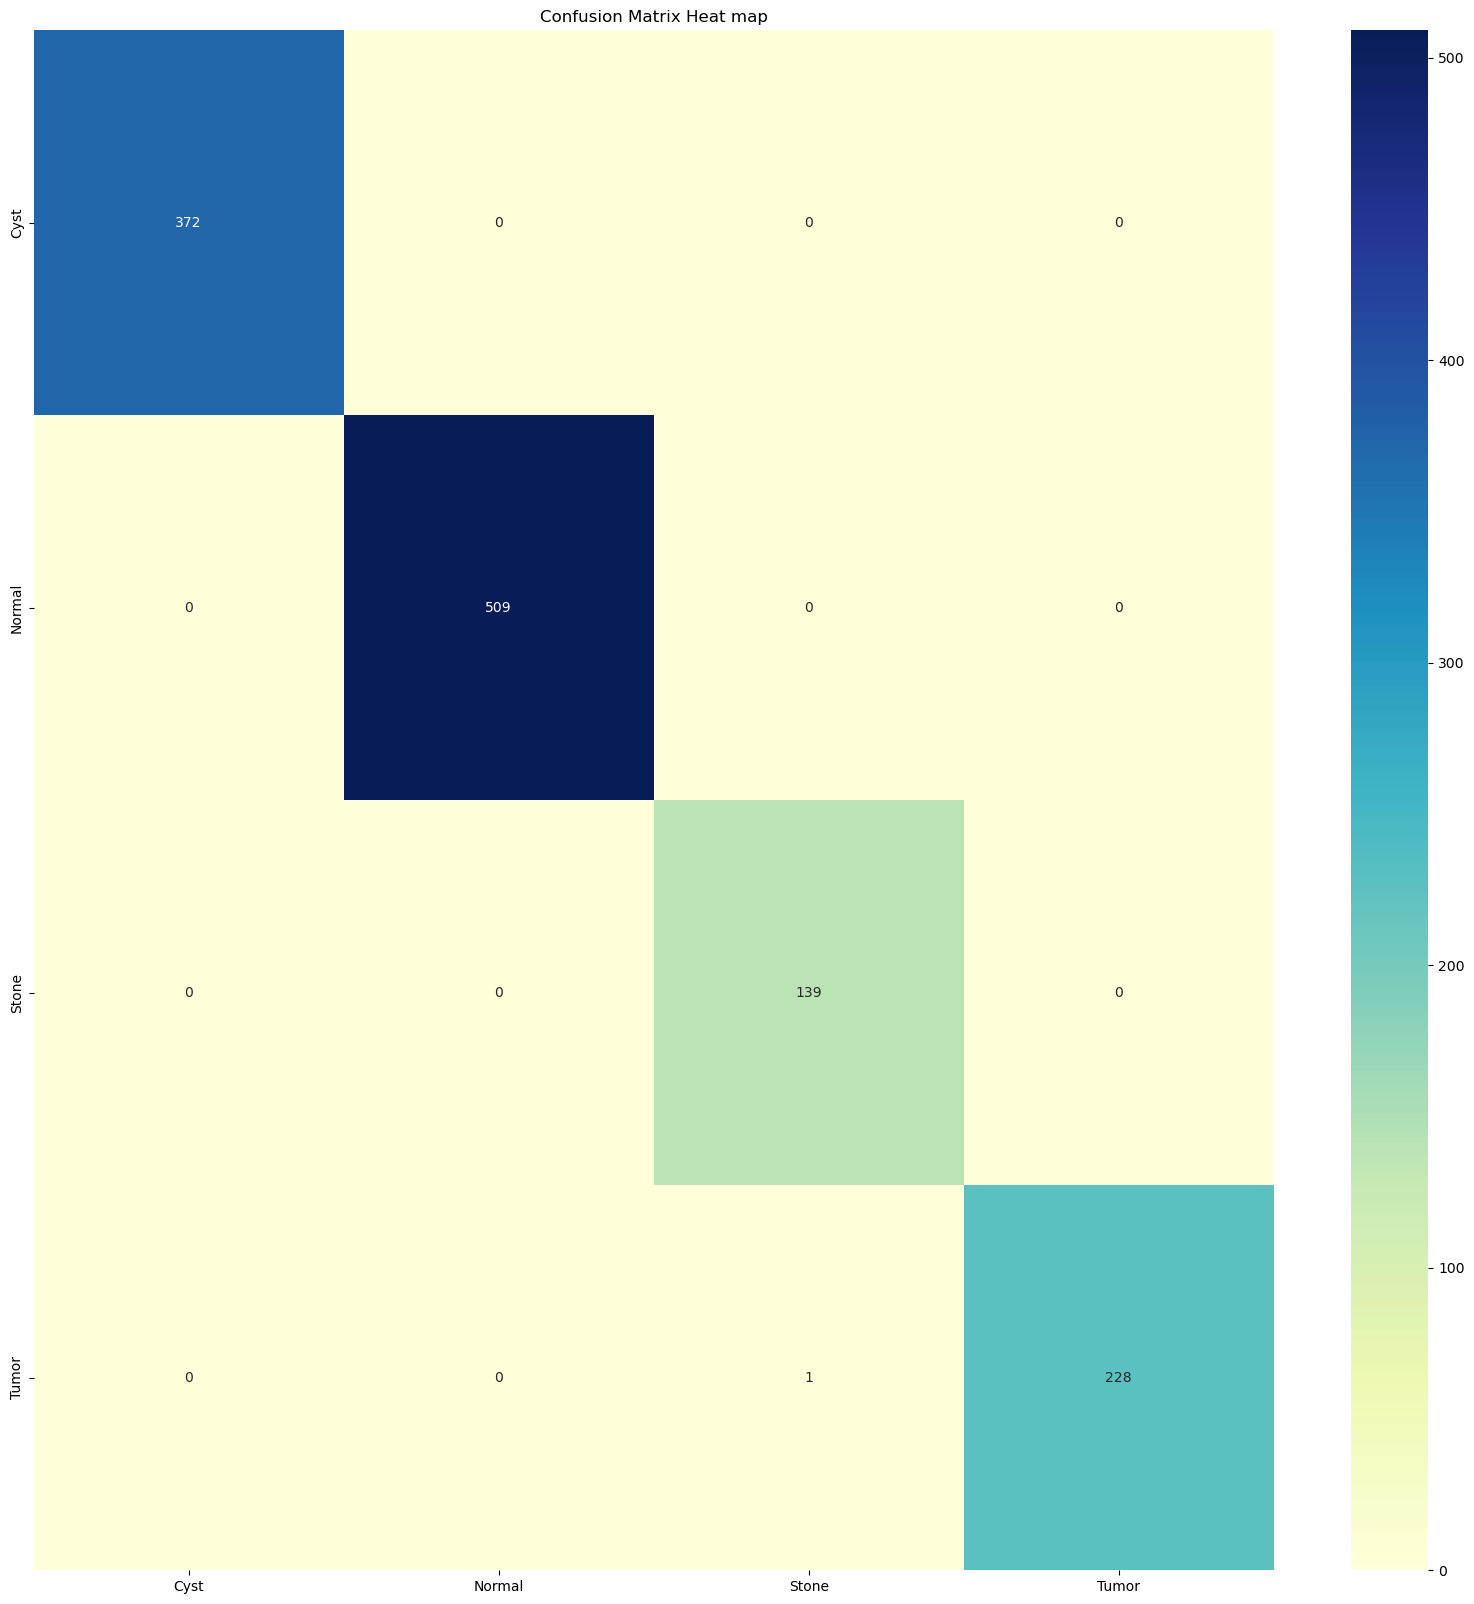

In [30]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

def evaluate(actual, predictions01):
  pre = []
  for i in predictions01:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()
    
evaluate(test_dataset.classes, predictions01)

In [31]:
inputs = keras.Input(shape=(180,180,3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(512,activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs = inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 128)       73856     
                                                             

In [32]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 
                                                                                   keras.metrics.Precision(name='precision'),
                                                                                   keras.metrics.Recall(name='recall')])
history02 = model.fit(train_dataset,
          validation_data=valid_dataset,
          epochs=10
         )

Epoch 1/10
100/100 [==============================] - 54s 455ms/step - loss: 1.4059 - accuracy: 0.4043 - precision: 0.4593 - recall: 0.0629 - val_loss: 1.1726 - val_accuracy: 0.5153 - val_precision: 0.7903 - val_recall: 0.2762
Epoch 2/10
100/100 [==============================] - 41s 408ms/step - loss: 1.0171 - accuracy: 0.6149 - precision: 0.6996 - recall: 0.4478 - val_loss: 0.8403 - val_accuracy: 0.6562 - val_precision: 0.7159 - val_recall: 0.5741
Epoch 3/10
100/100 [==============================] - 41s 411ms/step - loss: 0.3208 - accuracy: 0.8980 - precision: 0.9161 - recall: 0.8714 - val_loss: 0.1814 - val_accuracy: 0.9485 - val_precision: 0.9553 - val_recall: 0.9469
Epoch 4/10
100/100 [==============================] - 41s 405ms/step - loss: 0.0711 - accuracy: 0.9818 - precision: 0.9832 - recall: 0.9807 - val_loss: 0.0141 - val_accuracy: 0.9992 - val_precision: 0.9992 - val_recall: 0.9992
Epoch 5/10
100/100 [==============================] - 42s 416ms/step - loss: 0.0255 - accura

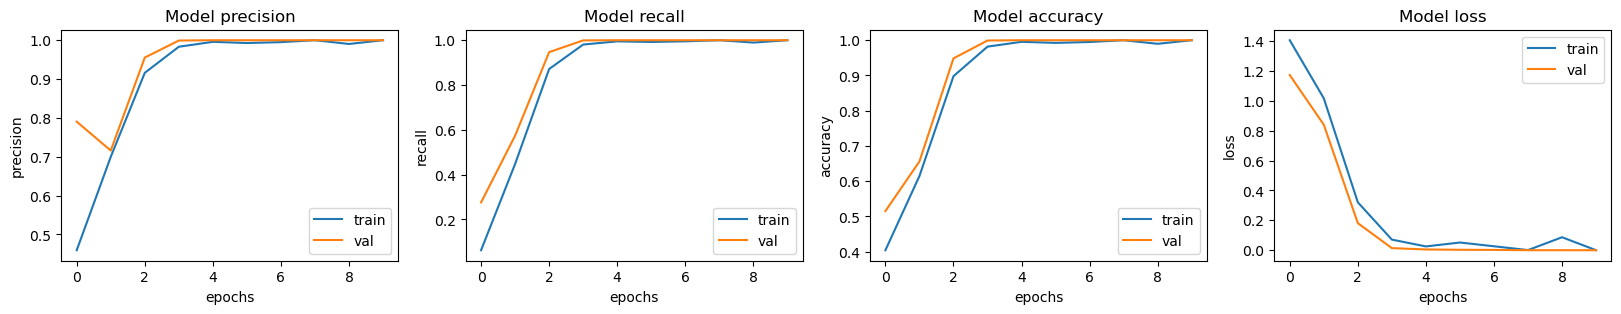

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history02.history[met])
    ax[i].plot(history02.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
predictions02 = model.predict(test_dataset)
model.evaluate(test_dataset)

13/13 [==============================] - 5s 352ms/step - loss: 0.0034 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992


[0.0033825382124632597,
 0.9991993308067322,
 0.9991993308067322,
 0.9991993308067322]

4/4 [==============================] - 1s 77ms/step


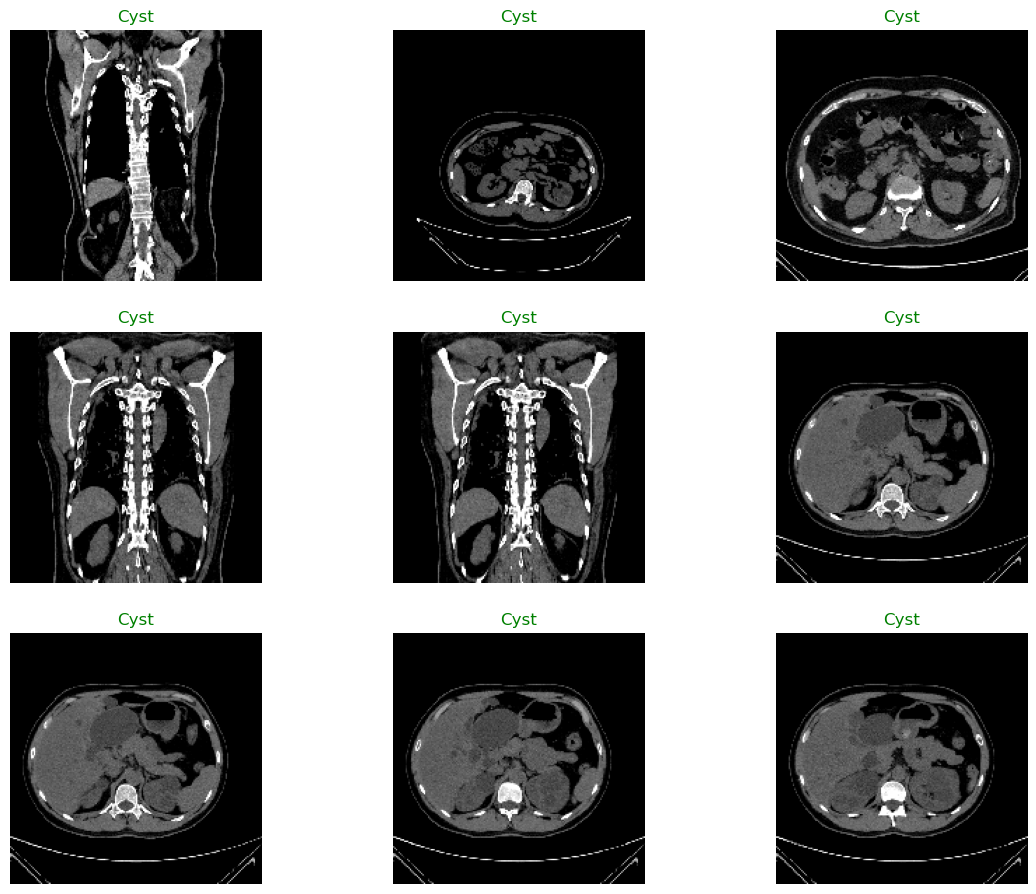

In [35]:
def class_prediction(dataset, n_images):
    i = 1
    images, labels = dataset.next()

    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = np.argmax(labels, axis= 1)
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    plt.show()

class_prediction(test_dataset, 10)

Accuracy: 0.9991993594875901
Precision: 0.9993297587131367
Recall: 0.9989082969432315
F1_score: 0.9991173835783413


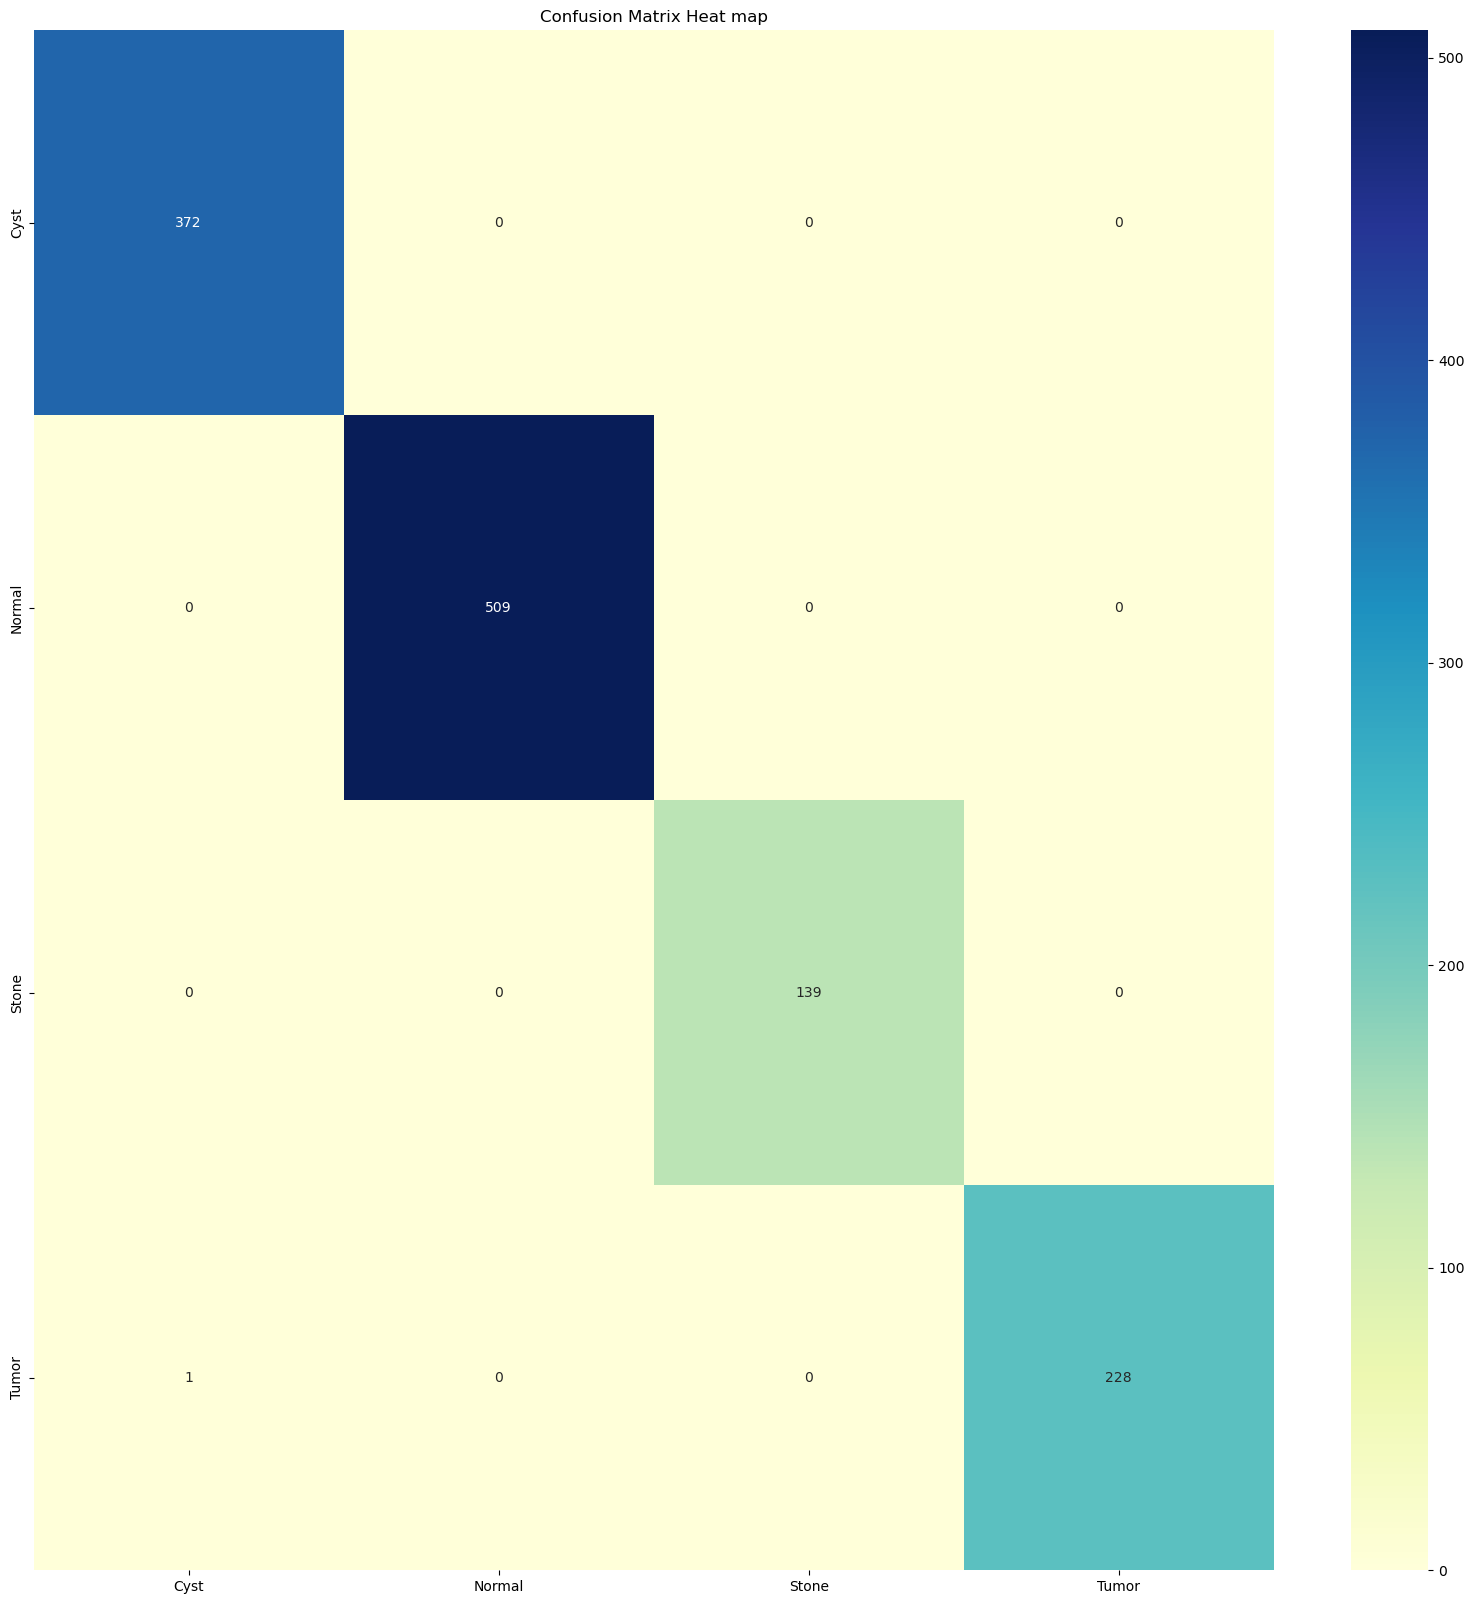

In [36]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

def evaluate(actual, predictions02):
  pre = []
  for i in predictions02:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(20,20))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()
    
evaluate(test_dataset.classes, predictions02)